In [ ]:
from astropy.table import Table
import torch

import matplotlib.pyplot as plt
from bliss.reporting import get_snr

import numpy as np

from bliss.datasets.lsst import prepare_final_galaxy_catalog, prepare_final_star_catalog
from bliss.datasets.table_utils import column_to_tensor

from pathlib import Path

from bliss.datasets.generate_blends import generate_dataset

from bliss.datasets.lsst import get_default_lsst_psf


In [ ]:
HOME_DIR = Path("../../../")
_cat = Table.read(HOME_DIR / "data" / "OneDegSq.fits")
_star_mags = column_to_tensor(Table.read(HOME_DIR / "data" / "stars_med_june2018.fits"), "i_ab")
CATSIM_CAT = prepare_final_galaxy_catalog(_cat)
STAR_MAGS = prepare_final_star_catalog(_star_mags)
len(CATSIM_CAT), len(STAR_MAGS)

(575903, 17077)

In [ ]:
N_SAMPLES = 1000

In [ ]:
psf = get_default_lsst_psf()

In [ ]:
from bliss.datasets.lsst import GALAXY_DENSITY, STAR_DENSITY


ds = generate_dataset(
                N_SAMPLES,
                CATSIM_CAT,
                STAR_MAGS,
                psf=psf,
                max_n_sources=10,
                galaxy_density=GALAXY_DENSITY,
                star_density=STAR_DENSITY,
                slen=40,
                bp=24,
                max_shift=0.5,
            )


100%|██████████| 1000/1000 [00:58<00:00, 17.03it/s]


In [ ]:
images = ds['images']
noiseless = ds['noiseless']
paddings = ds['paddings']
images.shape, noiseless.shape, paddings.shape, ds['uncentered_sources'].shape

(torch.Size([1000, 1, 88, 88]),
 torch.Size([1000, 1, 88, 88]),
 torch.Size([1000, 1, 88, 88]),
 torch.Size([1000, 10, 1, 88, 88]))

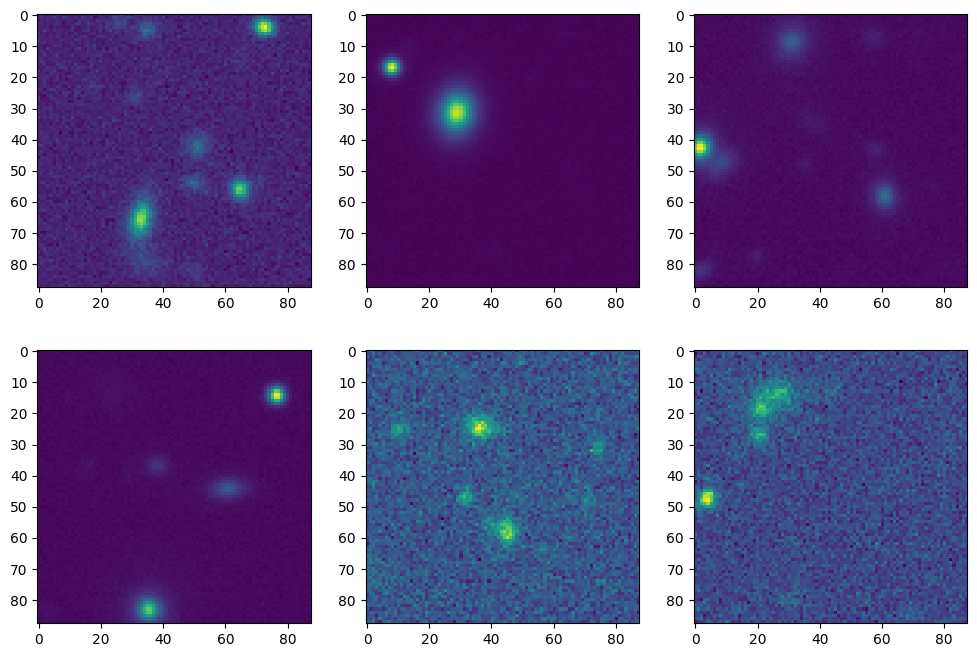

In [ ]:
# plot 6 example images of blends
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for ax in axs.flatten():
    idx = np.random.choice(np.arange(N_SAMPLES))
    ax.imshow(images[idx, 0])

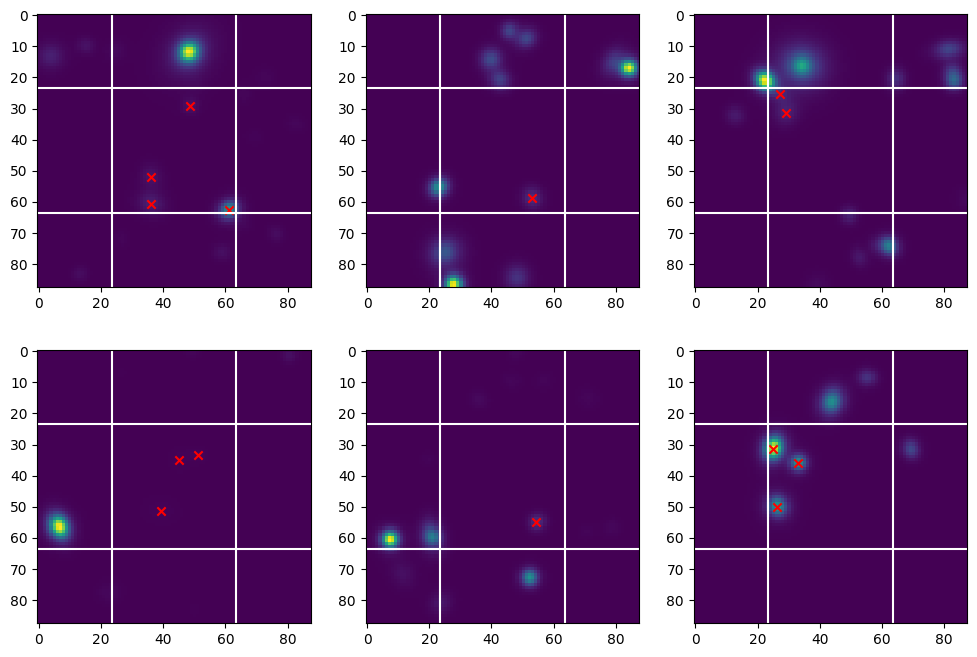

In [ ]:
# plot 6 example images of blends
# check locs 
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for ax in axs.flatten():
    idx = np.random.choice(np.arange(N_SAMPLES))
    ax.imshow(noiseless[idx, 0])
    plocs = ds['plocs'][idx]
    n_sources = ds['n_sources'][idx].item()
    for n in range(n_sources):
        y, x = plocs[n] - 0.5 + 24
        ax.scatter(x, y, color='r', marker='x')
    
    ax.axhline(24-0.5, color='w')
    ax.axhline(64-0.5, color='w')
    ax.axvline(24-0.5, color='w')
    ax.axvline(64-0.5, color='w')

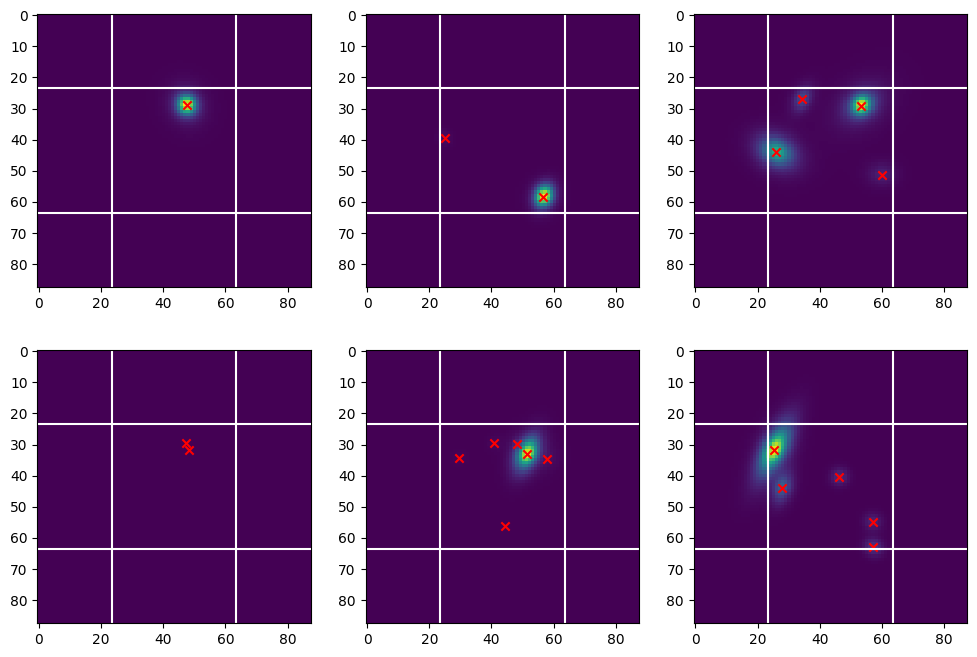

In [ ]:
# plot 6 example images of blends
# check paddings
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for ax in axs.flatten():
    idx = np.random.choice(np.arange(N_SAMPLES))
    ax.imshow(noiseless[idx, 0] - paddings[idx, 0])
    plocs = ds['plocs'][idx]
    n_sources = ds['n_sources'][idx].item()
    for n in range(n_sources):
        y, x = plocs[n] - 0.5 + 24
        ax.scatter(x, y, color='r', marker='x')
    
    ax.axhline(24-0.5, color='w')
    ax.axhline(64-0.5, color='w')
    ax.axvline(24-0.5, color='w')
    ax.axvline(64-0.5, color='w')

In [ ]:
# quick check on expected number of sources and obtained number of galaxies
ds['galaxy_bools'].sum(), GALAXY_DENSITY * 40 * 40  * 0.2 * 0.2 / 3600 * N_SAMPLES

(tensor(2882.), 2844.4444444444443)

In [ ]:
# quick check on expected number of stars
ds['star_bools'].sum(), STAR_DENSITY * 40 * 40  * 0.2 * 0.2 * N_SAMPLES  / 3600

(tensor(184.), 177.77777777777777)

In [ ]:
# check sampling of galaxy properties is correct with histograms
from bliss.reporting import get_single_galaxy_ellipticities
from tqdm import tqdm

mags = [] 
fluxes_img = []
ellips = []
for ii in tqdm(range(N_SAMPLES)):
    for n in range(ds['n_sources'][ii].item()):
        if ds['galaxy_bools'][ii][n].item() == 1:
            centered = ds['centered_sources'][ii, n]
            mags.append(ds['galaxy_params'][ii, n, -2])
            fluxes_img.append(centered.sum())
            ellips.append(get_single_galaxy_ellipticities(centered.reshape(1, 88, 88)))




  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 662.30it/s]


In [ ]:
ellips[0].shape

torch.Size([1, 2])

In [ ]:
from einops import pack
mags_tensor, _ = pack(mags, '*')
fluxes_tensor, _ = pack(fluxes_img, '*')
ellips_tensor, _= pack(ellips, '* xy')

mags_tensor.shape, fluxes_tensor.shape, ellips_tensor.shape

(torch.Size([2882]), torch.Size([2882]), torch.Size([2882, 2]))

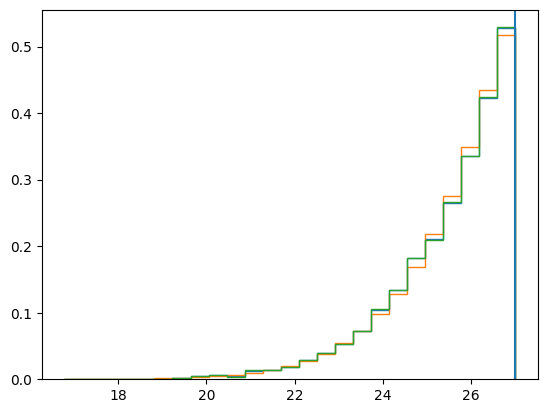

In [ ]:
from bliss.datasets.lsst import convert_flux_to_mag


mags_img = convert_flux_to_mag(fluxes_tensor)

_, bins, _ = plt.hist(mags_tensor.numpy(), bins=25, density=True, histtype='step')
plt.hist(CATSIM_CAT['i_ab'].value, bins=bins, density=True, histtype='step')
plt.hist(mags_img, bins=bins, density=True, histtype='step')
plt.axvline(27.0)

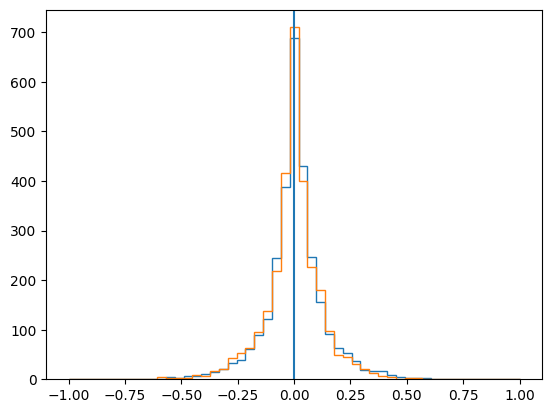

In [ ]:
_, bins, _ = plt.hist(ellips_tensor[:, 0], histtype='step', bins=51, range=(-1.0, 1.0))
plt.hist(ellips_tensor[:, 1], histtype='step', bins=bins)
plt.axvline(0.0)